In [104]:
import numpy as np

import sys
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import torch
import re
import time
import numpy as np
import random
from english_words import get_english_words_set
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import copy
import pkg_resources
from symspellpy import SymSpell, Verbosity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use gpu if available



In [105]:
# %%
def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  
seed_everything()

In [106]:
web2lowerset = get_english_words_set(['web2'], lower=True)
gcidelowerset = get_english_words_set(['gcide'], lower=True)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=10)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [107]:
# Data format: each data point is comprised of a list of integers
# between 0 and 255.

def load_data(filename):
    with open(filename) as f:
        labels = []
        points = []
        for line in f.readlines():
            data = line.split(',')
            if int(data[0]) < 36: 
                labels.append(int(data[0]))
                points.append([int(x) for x in data[1:]])
        points = np.array(points)
        labels = np.array(labels)
        return points, labels


#Append the directory to your python path using sys
# prefix = '/content/drive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'EMNIST_Datasets'
sys_path = customized_path_to_your_homework
sys.path.append(sys_path)
# print(sys.path)

fn_train = os.path.join(sys_path, 'emnist-balanced-train.csv')
fn_test = os.path.join(sys_path, 'emnist-balanced-test.csv')
print('Path to training data: {}'.format(fn_train))
print('Path to testing data: {}'.format(fn_test))

Path to training data: EMNIST_Datasets\emnist-balanced-train.csv
Path to testing data: EMNIST_Datasets\emnist-balanced-test.csv


In [108]:
train_data, train_labs = load_data(fn_train)
test_data, test_labs = load_data(fn_test)

In [109]:
test_data = test_data.astype('float32')
train_data = train_data.astype('float32')
for iter in range(0, len(test_data)):
    test_data[iter] = np.true_divide(test_data[iter], 255)
for iter in range(0, len(train_data)):
    train_data[iter] = np.true_divide(train_data[iter], 255)

In [110]:
# Create the Multinomial Naive Bayes Classifi
NaiveBayes = MultinomialNB()
# Perform the predictions
NaiveBayes.fit(train_data,train_labs)
# Perform the predictions


MultinomialNB()

In [112]:


# Create a RandomForestClassifier object
randomForest = RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=1,max_samples= None, max_features= 'sqrt', max_depth= 30, criterion= 'gini', class_weight= None, bootstrap= False)

# Fit the RandomForestClassifier object to your data
randomForest.fit(train_data, train_labs)



RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=400)

In [113]:
# Create a KNeighborsClassifier object
KNeighbors = KNeighborsClassifier(weights='distance', p=1,n_neighbors=7,n_jobs=-1,metric='euclidean',leaf_size=48,algorithm='auto')

# Fit the KNeighborsClassifier object to your data
KNeighbors.fit(train_data, train_labs)


KNeighborsClassifier(leaf_size=48, metric='euclidean', n_jobs=-1, n_neighbors=7,
                     p=1, weights='distance')

In [114]:

# Print the score on the training data
print("Training Score:", NaiveBayes.score(train_data, train_labs))

# Print the score on the test data
print("Test Score:", NaiveBayes.score(test_data, test_labs))


# Print the score on the training data
print("Training Score:", KNeighbors.score(train_data, train_labs))

# Print the score on the test data
print("Test Score:", KNeighbors.score(test_data, test_labs))


# Print the score on the training data
print("Training Score:", randomForest.score(train_data, train_labs))

# Print the score on the test data
print("Test Score:", randomForest.score(test_data, test_labs))


Training Score: 0.5796296296296296
Test Score: 0.58125
Training Score: 1.0
Test Score: 0.7590277777777777
Training Score: 1.0
Test Score: 0.80625


In [115]:
def emnist_to_dictionary():
    label_dictionary = {}
    for iter in range(len(test_data)):
        if int(test_labs[iter]) in label_dictionary:
            label_dictionary[int(test_labs[iter])].append(test_data[iter])
        else:
            label_dictionary[int(test_labs[iter])] = [test_data[iter]]
    return label_dictionary

def load_string_emnist_mappings():
    with open("EMNIST_Datasets/emnist-balanced-mapping.txt") as f:
        emnist_mapping = {}
        for line in f.readlines():
            data = line.strip().split(' ')
            emnist_mapping[int(data[1])] = int(data[0])
        return emnist_mapping
    
def load_emnist_string_mappings():
    with open("EMNIST_Datasets/emnist-balanced-mapping.txt") as f:
        emnist_mapping = {}
        for line in f.readlines():
            data = line.strip().split(' ')
            emnist_mapping[int(data[0])] = int(data[1])
        return emnist_mapping

In [116]:
emnist_dictionary = emnist_to_dictionary()
string_emnist_mappings = load_string_emnist_mappings()
emnist_string_mappings = load_emnist_string_mappings()

In [117]:
def cleanString(message):
    # .,-(:)";/[]$&%+?=!#{}\
    pattern = re.compile('[^A-Za-z0-9\s\']+', re.UNICODE)
    cleaned_message = pattern.sub('', message)
    return cleaned_message.strip().lower()


def convertToEMNIST(message):
    message_conversion = []
    for word in message.split(' '):
        for char in word:
            if char.isalnum():
                if ord(char) in string_emnist_mappings:
                    emnist_index = string_emnist_mappings[ord(char)]
                else:
                    emnist_index = string_emnist_mappings[ord(char.swapcase())]
                image_list = emnist_dictionary[emnist_index]
                image_pick = random.randint(0,len(image_list)-1)
                message_conversion.append(image_list[image_pick])
            else: 
                message_conversion.append(char)
        message_conversion.append(' ')
    return message_conversion
        

def predict(emnist_message, model):
    predicted_message = []
    k = 5
    test_pbar = tqdm(emnist_message, total=len(emnist_message))
    for char in test_pbar:
        if not isinstance(char, str):
            proba = model.predict_proba(char.reshape(1, -1))
            top_k_proba_indices = np.argsort(proba, axis=1)[:, ::-1][:, :k]
            top_k_proba_values = np.take_along_axis(proba, top_k_proba_indices, axis=1)
            top_k_class_labels = np.take(model.classes_, top_k_proba_indices)
            
            top_k_class_labels = torch.from_numpy(top_k_class_labels[0]).to(device)
            top_k_proba_values = torch.from_numpy(top_k_proba_values[0]).to(device)
            
            mask = top_k_proba_values >= 0.001
            top_k_proba_values = top_k_proba_values[mask]
            top_k_class_labels = top_k_class_labels[mask]     
            top_k_proba_values = torch.round(top_k_proba_values * 100) / 100
            predicted_message.append(zip(top_k_class_labels,top_k_proba_values))
        else:
            predicted_message.append(char)
    return predicted_message


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jaydo\AppData\Local\Temp\ipykernel_18244\2067257207.py:3: SyntaxWarning: invalid escape sequence '\s'
  pattern = re.compile('[^A-Za-z0-9\s\']+', re.UNICODE)


In [118]:
def checkExistence(wordList):
    validWordList = []
    mostlyValidWordList = []
    somewhatValidWordList = []
            
    for word in wordList:
        if len(sym_spell.lookup(word, Verbosity.ALL, max_edit_distance=0)) > 0:
            somewhatValidWordList.append(word)
        if word in web2lowerset:
            if word in somewhatValidWordList:
                somewhatValidWordList.pop()
                mostlyValidWordList.append(word)
            else:
                somewhatValidWordList.append(word)
        if word in gcidelowerset:
            if word in mostlyValidWordList:
                mostlyValidWordList.pop()
                validWordList.append(word)
            if word in somewhatValidWordList:
                somewhatValidWordList.pop()
                mostlyValidWordList.append(word)
            else:
                somewhatValidWordList.append(word)

    if len(validWordList) > 0:
        return validWordList, False
    elif len(mostlyValidWordList) > 0:
        return mostlyValidWordList, False
    elif len(somewhatValidWordList) > 0:
        return somewhatValidWordList, False
    else:
        return wordList, True
    
def spellCorrection(real_words_list, distance):
    for possible_word in real_words_list:
        candidates = sym_spell.lookup(possible_word, Verbosity.ALL, max_edit_distance=distance)
        if candidates is not None:
            for candidate in candidates:
                if len(candidate.term) == len(real_words_list[0]):
                    return candidate.term
    return None    

def add_probable_characters(possible_chars, wordList, contains_numbers, minimum_viable_probability):
    top_indices, top_probs = zip(*possible_chars)
    newWordList = []
    temp_contains_numbers = False
    somethingAppended = False
    valid_characters = []
    for index in range(0,len(top_indices)):
        if top_probs[index] > minimum_viable_probability:
            if int(top_indices[index]) < 10:
                if contains_numbers:
                    temp_contains_numbers = True
                    somethingAppended = True
                    valid_characters.append(chr(emnist_string_mappings[int(top_indices[index])]))
            else:
                valid_characters.append(chr(emnist_string_mappings[int(top_indices[index])]))
                somethingAppended = True
        elif not somethingAppended:
            if int(top_indices[index]) < 10:
                if contains_numbers:
                    temp_contains_numbers = True
                    somethingAppended = True
                    valid_characters.append(chr(emnist_string_mappings[int(top_indices[index])]))
            else:
                valid_characters.append(chr(emnist_string_mappings[int(top_indices[index])]))
                somethingAppended = True
                
    if not somethingAppended:
        somethingAppended = True
        valid_characters.append(chr(emnist_string_mappings[int(top_indices[0])]))
            
    for word in wordList:
        for char in valid_characters:
            newWordList.append(word + char)
            
    return newWordList, temp_contains_numbers

def convertToString(message, mode, minimum_viable_probability):

    final_string = ""
    wordList = [""]
    contains_numbers = True
    for char in message:
        if not isinstance(char, str):
            wordList, contains_numbers = add_probable_characters(char, wordList, contains_numbers, minimum_viable_probability)
        elif char == '\'':
            final_string += char
            contains_numbers = True
            
        elif len(wordList[0]) > 0:
            processing = True
            real_words_list = []
            if contains_numbers:
                for word in wordList:
                    if(all(char.isdigit() for char in word)):
                        final_string += word
                        processing = False
                        break
            if processing:
                filterNumbers = []
                for word in wordList:
                    if all(char.isalpha() for char in word):
                        filterNumbers.append(word.lower()) 
                real_words_list = filterNumbers
            if mode > 1:             
                if processing:
                    real_words_list, processing = checkExistence(real_words_list)
                    if not processing:
                        final_string += real_words_list[0]
                                
                if mode > 2:             
                    if processing:
                        correction = spellCorrection(real_words_list, 1)    
                        if correction is not None:
                            final_string += correction
                            processing = False
                            
                    if mode > 3:                 
                        if processing and len(wordList[0]) > 6:            
                            correction = spellCorrection(real_words_list, 2)    
                            if correction is not None:
                                final_string += correction
                                processing = False
                                
                        if mode > 4: 
                            if processing and len(wordList[0]) > 12:            
                                correction = spellCorrection(real_words_list, 3)    
                                if correction is not None:
                                    final_string += correction
                                    processing = False
                
            if processing:
                if len(real_words_list) > 0:
                    final_string += real_words_list[0]
                else:
                    final_string += wordList[0]
                processing = False
                
            final_string += char
            contains_numbers = True
            wordList = [""]
            
        else:
            final_string += char
            contains_numbers = True
            wordList = [""]
            
    return final_string

def readMessage(prediction, mode, minimum_viable_probability):
    if mode == 0:
        final_string = ""
        for char in prediction:
            if not isinstance(char, str):
                top_indices, _ = zip(*char)
                final_string += chr(emnist_string_mappings[int(top_indices[0])])
            else:
                final_string += char
        return final_string
    else:
        return convertToString(prediction, mode, minimum_viable_probability).strip()



In [119]:
def gather_data(model):
    with open('paragraphs.txt/paragraphs.txt') as paragraphs:
        total_predictions = 0
        code_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
        metrics_100_predictions = {"word_accuracy": copy.deepcopy(code_dict), "char_accuracy": copy.deepcopy(code_dict), "time":copy.deepcopy(code_dict),"prediction_time":[]}
        for start, line in enumerate(paragraphs.readlines(), start = 0):
            if start % 300 == 0:
                line = cleanString(line)
                emnist_conversion = convertToEMNIST(line.upper())
                prediction_time = time.time_ns() // 1000000        
                prediction = predict(emnist_conversion, model)
                prediction_time = time.time_ns() // 1000000 - prediction_time
                metrics_100_predictions["prediction_time"].append(prediction_time)
                total_predictions += 1
                for code in (0, 1, 2, 3, 4, 5):
                    minimum_viable_probability = 0.1
                    start = time.time_ns() // 1000000
                    translation = readMessage(copy.deepcopy(prediction), code, minimum_viable_probability).strip()
                    end = time.time_ns() // 1000000
                    metrics_100_predictions["time"][code].append(end-start)
                    direct_correct = 0
                    for iter in range(len(line)):
                        originalLine = line[iter].lower()
                        if line[iter].isalnum():
                            if originalLine == translation[iter].lower() :
                                direct_correct += 1
                    
                    metrics_100_predictions["char_accuracy"][code].append(direct_correct/len(line))
                    direct_correct = 0
                    translation_compare = translation.split(" ")
                    word_compare =  line.split(" ")
                    for iter in range(len(word_compare)):
                        if word_compare[iter].lower() == translation_compare[iter].lower():
                            direct_correct += 1

                    metrics_100_predictions["word_accuracy"][code].append(direct_correct/len(word_compare))
                if total_predictions > 50:
                    break
        return metrics_100_predictions

In [120]:
seed_everything()
naive_bayes_data = gather_data(NaiveBayes)
seed_everything()
random_forest_data = gather_data(randomForest)
seed_everything()
k_nearest_data = gather_data(KNeighbors)
seed_everything()

100%|██████████| 102/102 [00:02<00:00, 47.95it/s]


In [121]:
# %%

from torchvision import transforms, datasets
from torchvision.transforms import Normalize, ToTensor
import os
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import ssl
import torchmetrics
from torchinfo import summary
from torchsummary import summary as testValid
import time
import io
from torch.optim import Adam, RMSprop, sgd
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from matplotlib import pyplot as plt
import numpy as np
import random
import re, string
from english_words import get_english_words_set
ssl._create_default_https_context = ssl._create_unverified_context
with open('models.txt','r') as file:
    HIGHEST_TEST_ACC = float(file.readline())
EPOCHS = 10
INIT_LR = 1e-3
BATCH_SIZE = 100
TRAIN_SPLIT = 0.8
VAL_SPLIT = 1 - TRAIN_SPLIT
import copy
import pkg_resources
from symspellpy import SymSpell, Verbosity
web2lowerset = get_english_words_set(['web2'], lower=True)
gcidelowerset = get_english_words_set(['gcide'], lower=True)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=10)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)




# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use gpu if available
mnist_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=0.15, std=0.3)])
train_val_data = datasets.EMNIST(
    root = 'CNN_Datasets',
    train = True,                         
    transform = mnist_transforms, 
    download = True,
    split='balanced'            
)
test_data = datasets.EMNIST(
    root = 'CNN_Datasets', 
    train = False, 
    transform = mnist_transforms,
    download = True,
    split='balanced'
)

# %%
import torch
train_val_data = [item for item in train_val_data if item[1] < 36]
test_data = [item for item in test_data if item[1] < 36]
# Assuming you have defined TRAIN_SPLIT and VAL_SPLIT previously
train_data, val_data = torch.utils.data.random_split(dataset=train_val_data, lengths=[TRAIN_SPLIT, VAL_SPLIT])

# Remove all occurrences of 28 from train_data

# Now train_data_no_28 contains all elements from train_data except those with the value 28


# %%

from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),
    'val' : torch.utils.data.DataLoader(val_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),    
    'utility'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=1, 
                                          shuffle=False, 
                                          num_workers=1),
}



# %%
import torch.nn as nn
import torch.nn.functional as F





In [122]:
# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding='same'),
            nn.MaxPool2d(2),
            nn.LeakyReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2),
            nn.LeakyReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2),
            nn.LeakyReLU()
        )
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.25)
        )
        self.label = nn.Sequential(
            nn.Linear(512, 47),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):

        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        # x = self.deep(x)
        x = self.label(x)

        return x

# loop over our epochs
def train(model, opt, lossFn):
	# best_validation = 0
	for epoch in range(0, EPOCHS):
		model.train().to(device)
		# set the model in training mode
		# initialize the total training and validation loss
		train_loss = 0.0
		# initialize the number of correct predictions in the training
		# and validation step
		# loop over the training set
		train_pbar = tqdm(loaders['train'], total=len(train_data)//BATCH_SIZE)
		for index,(x,y) in enumerate(train_pbar,start=1):
			# send the input to the device
			x, y = x.to(device), y.to(device)
			# perform a forward pass and calculate the training loss
			opt.zero_grad()
			pred = model(x).to(device)
			# zero out the gradients, perform the backpropagation step,
			# and update the weights

			loss = lossFn(pred, y).to(device)
			loss.backward()
			opt.step()
			train_loss += loss.item()
			train_pbar.set_description(f"Epoch {epoch}, loss: {train_loss / index:.4f}")
		# switch off autograd for evaluation
		model.eval().to(device)
		correct, loss_sum = 0, 0
		valLength = len(val_data)//BATCH_SIZE
		val_pbar = tqdm(loaders['val'], total=valLength)
		with torch.no_grad():
			for index,(x,y) in enumerate(val_pbar,start=1):
				x, y = x.to(device), y.to(device)
				
				pred = model(x).to(device)
				loss = lossFn(pred, y).to(device)
				loss_sum += loss.item() / y.size(0)
				preds = pred.data.max(1, keepdim=True)[1].to(device)
				correct += preds.eq(y.data.view_as(preds).to(device)).sum() / y.size(0)
				val_pbar.set_description(f"val_loss: {loss_sum / index:.4f}, val_accuracy: {correct / index:.4f}")
			# if(correct/valLength > best_validation):
			# 	torch.save(model.state_dict(), 'training-model-parameters.pt')
			# 	best_validation = correct/len(val_data)//BATCH_SIZE
    
	

# %%
def test(model, lossFn):
	model.eval().to(device)
	test_correct, test_loss_sum = 0, 0
	test_pbar = tqdm(loaders['test'], total=len(test_data)//BATCH_SIZE)
	with torch.no_grad():
		for index,(x,y) in enumerate(test_pbar,start=1):
			x, y = x.to(device), y.to(device)
			
			pred = model(x).to(device)
			loss = lossFn(pred, y).to(device)
			test_loss_sum += loss.item() / y.size(0)
			preds = pred.data.max(1, keepdim=True)[1].to(device)
			test_correct += preds.eq(y.data.view_as(preds)).sum() / y.size(0)
			test_pbar.set_description(f"test_accuracy: {test_correct / index:.4f}")
	test_acc = test_correct.item()/len(test_pbar)
	if(test_acc > HIGHEST_TEST_ACC):
		with io.open('models.txt', 'w', encoding='utf-8') as file:
			file.write(str(test_acc))
			file.write('\n')
			model_stats = summary(model, input_size=(BATCH_SIZE,1, 28, 28), device=device, verbose=2)
			file.write(str(model_stats))
# print(f"Epoch: {epoch}| Train loss: {train_loss / train_iter: .4f}| Train acc: {train_acc / train_iter: .4f}| Val loss: {loss_sum/val_iter: .5f}| Val acc: {correct/val_iter: .4f}")
# generate a classification report



In [123]:

# %%
# initialize the LeNet model
model = Net()
model = model.to(device)
testValid(model, (1, 28, 28), BATCH_SIZE ,device=str(device))

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
# initialize a dictionary to store training history

lossFn = nn.CrossEntropyLoss()
# measure how long training is going to take

print("[INFO] training the network...")
startTime = time.time()
train(model,opt,lossFn)
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
print("[INFO] evaluating network...")
test(model,lossFn)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 64, 28, 28]             640
         MaxPool2d-2          [100, 64, 14, 14]               0
         LeakyReLU-3          [100, 64, 14, 14]               0
            Conv2d-4         [100, 256, 12, 12]         147,712
         Dropout2d-5         [100, 256, 12, 12]               0
         MaxPool2d-6           [100, 256, 6, 6]               0
         LeakyReLU-7           [100, 256, 6, 6]               0
            Conv2d-8           [100, 512, 4, 4]       1,180,160
         Dropout2d-9           [100, 512, 4, 4]               0
        MaxPool2d-10           [100, 512, 2, 2]               0
        LeakyReLU-11           [100, 512, 2, 2]               0
          Flatten-12                [100, 2048]               0
           Linear-13                 [100, 512]       1,049,088
        LeakyReLU-14                 [1

Epoch 0, loss: 0.5715: : 692it [01:58,  5.82it/s]                         
val_loss: 0.0029, val_accuracy: 0.8956: : 173it [00:21,  8.01it/s]                        
Epoch 1, loss: 0.2947: : 692it [00:42, 16.42it/s]                       
val_loss: 0.0026, val_accuracy: 0.9056: : 173it [00:28,  6.16it/s]                       
Epoch 2, loss: 0.2566: : 692it [00:32, 21.53it/s]                       
val_loss: 0.0024, val_accuracy: 0.9097: : 173it [00:21,  8.16it/s]                       
Epoch 3, loss: 0.2323: : 692it [00:31, 21.92it/s]                       
val_loss: 0.0024, val_accuracy: 0.9031: : 173it [00:19,  8.66it/s]                       
Epoch 4, loss: 0.2154: : 692it [00:31, 22.20it/s]                       
val_loss: 0.0024, val_accuracy: 0.9133: : 173it [00:21,  8.02it/s]                       
Epoch 5, loss: 0.2021: : 692it [00:32, 21.58it/s]                       
val_loss: 0.0023, val_accuracy: 0.9129: : 173it [00:20,  8.31it/s]                       
Epoch 6, loss: 0.18

[INFO] total time taken to train the model: 628.50s
[INFO] evaluating network...


test_accuracy: 0.9164: 100%|██████████| 144/144 [00:34<00:00,  4.18it/s]


In [124]:
      

def predict(emnist_message, model):
    predicted_message = []
    model.eval().to(device)
    test_pbar = tqdm(emnist_message, total=len(emnist_message))
    with torch.no_grad():
        for x in test_pbar:
            if not isinstance(x, str):
                x = x.reshape(1,1,28,28).to(device)
                
                preds = model(x).to(device)
                probs = torch.softmax(preds, dim=1).to(device)
                
                # Get top 3 probabilities                
                top_probs, top_indices = torch.topk(probs, k=5, dim=1)   
                mask = top_probs >= 0.001
                top_probs = top_probs[mask]
                top_indices = top_indices[mask]     
                top_probs = torch.round(top_probs * 100) / 100
                predicted_message.append(zip(top_indices,top_probs))
            else:
                predicted_message.append(x)
    return predicted_message

seed_everything()
with open('paragraphs.txt/paragraphs.txt') as paragraphs:
    total_predictions = 0
    probability_dict = {0.2:[], 0.1:[], 0.05:[], 0.025:[], 0.01:[]}
    code_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
    metrics_100_predictions = {"word_accuracy": copy.deepcopy(code_dict), "char_accuracy": copy.deepcopy(code_dict), "time":copy.deepcopy(code_dict),"prediction_time":[]}
    for start, line in enumerate(paragraphs.readlines(), start = 0):
        if start % 300 == 0:
            line = cleanString(line)
            emnist_conversion = convertToEMNIST(line.upper())
            prediction_time = time.time_ns() // 1000000        
            prediction = predict(emnist_conversion, model)
            prediction_time = time.time_ns() // 1000000 - prediction_time
            metrics_100_predictions["prediction_time"].append(prediction_time)
            total_predictions += 1
            for code in (0, 1, 2, 3, 4, 5):
                minimum_viable_probability = 0.1
                # for minimum_viable_probability in (0.2, 0.1, 0.05, 0.025):
                start = time.time_ns() // 1000000
                translation = readMessage(copy.deepcopy(prediction), code, minimum_viable_probability).strip()
                end = time.time_ns() // 1000000
                metrics_100_predictions["time"][code].append(end-start)
                direct_correct = 0
                for iter in range(len(line)):
                    originalLine = line[iter].lower()
                    if line[iter].isalnum():
                        if originalLine == translation[iter].lower() :
                            direct_correct += 1
                
                metrics_100_predictions["char_accuracy"][code].append(direct_correct/len(line))
                direct_correct = 0
                translation_compare = translation.split(" ")
                word_compare =  line.split(" ")
                for iter in range(len(word_compare)):
                    if word_compare[iter].lower() == translation_compare[iter].lower():
                        direct_correct += 1

                metrics_100_predictions["word_accuracy"][code].append(direct_correct/len(word_compare))
            if total_predictions > 50:
                break

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jaydo\AppData\Local\Temp\ipykernel_18244\3247200663.py:35: SyntaxWarning: invalid escape sequence '\s'
  pattern = re.compile('[^A-Za-z0-9\s\']+', re.UNICODE)
100%|██████████| 102/102 [00:00<00:00, 626.18it/s]


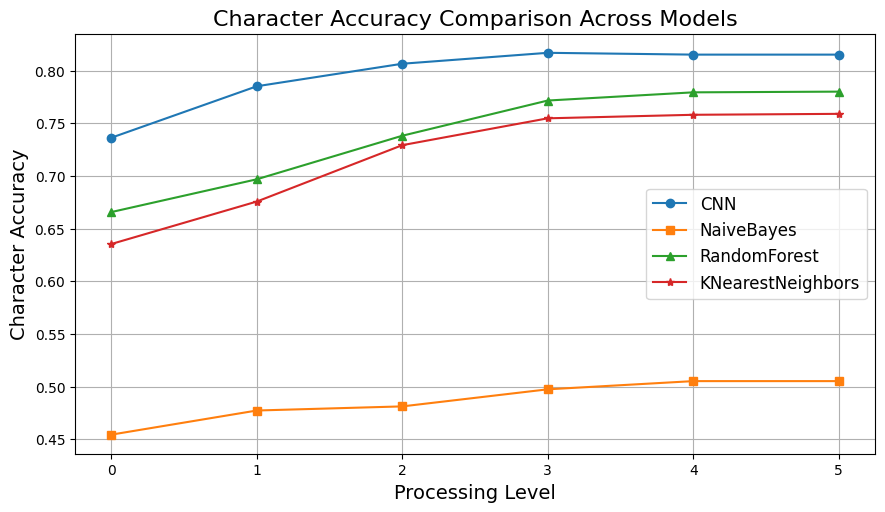

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the metric_100_predictions dictionary already populated

# Create a list of codes for the x-axis
codes = list(range(6))

# Create separate lists for word_accuracy for each data set
original_word_accuracy = [np.mean(metrics_100_predictions["char_accuracy"][code]) for code in codes]
naivebayes_word_accuracy = [np.mean(naive_bayes_data["char_accuracy"][code]) for code in codes]
randomforest_word_accuracy = [np.mean(random_forest_data["char_accuracy"][code]) for code in codes]
knn_word_accuracy = [np.mean(k_nearest_data["char_accuracy"][code]) for code in codes]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the word accuracy for each data set as separate lines
ax.plot(codes, original_word_accuracy, marker='o', label='CNN')
ax.plot(codes, naivebayes_word_accuracy, marker='s', label='NaiveBayes')
ax.plot(codes, randomforest_word_accuracy, marker='^', label='RandomForest')
ax.plot(codes, knn_word_accuracy, marker='*', label='KNearestNeighbors')

# Set the x-axis and y-axis labels
ax.set_xlabel('Processing Level', fontsize=14)
ax.set_ylabel('Character Accuracy', fontsize=14)

# Set the x-axis tick labels to the codes
ax.set_xticks(codes)

# Add a title
ax.set_title('Character Accuracy Comparison Across Models', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Add grid lines
ax.grid(True)

# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the metric_100_predictions dictionary already populated

# Create a list of codes for the x-axis
codes = list(range(6))

# Create separate lists for word_accuracy for each data set
original_word_accuracy = [np.mean(metrics_100_predictions["word_accuracy"][code]) for code in codes]
naivebayes_word_accuracy = [np.mean(naive_bayes_data["word_accuracy"][code]) for code in codes]
randomforest_word_accuracy = [np.mean(random_forest_data["word_accuracy"][code]) for code in codes]
knn_word_accuracy = [np.mean(k_nearest_data["word_accuracy"][code]) for code in codes]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the word accuracy for each data set as separate lines
ax.plot(codes, original_word_accuracy, marker='o', label='CNN')
ax.plot(codes, naivebayes_word_accuracy, marker='s', label='NaiveBayes')
ax.plot(codes, randomforest_word_accuracy, marker='^', label='RandomForest')
ax.plot(codes, knn_word_accuracy, marker='*', label='KNearestNeighbors')

# Set the x-axis and y-axis labels
ax.set_xlabel('Processing Level', fontsize=14)
ax.set_ylabel('Word Accuracy', fontsize=14)

# Set the x-axis tick labels to the codes
ax.set_xticks(codes)

# Add a title
ax.set_title('Word Accuracy Comparison Across Models', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Add grid lines
ax.grid(True)

# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()